# Estimacion de produccion de Aceite

In [137]:
#triada de la death
import pandas as pd
import numpy as np

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (12,8)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }

plt.style.use('ggplot')

# Modelos
import lightgbm as lgb
from sklearn.cluster import KMeans

# Interpretacion
import shap
from pdpbox import pdp, info_plots

#mis tools
import sys
sys.path.append('../serch_tools/')
import serch_tools as st

In [138]:
aforos = pd.read_csv("datos/aforos.csv")
analisis_fluidos = pd.read_csv("datos/Analisis_fluidos.csv")
columna_geologica = pd.read_csv('datos/columna_geologica.csv')
eval_petrofisica = pd.read_csv('datos/eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('datos/IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('datos/parametros_petrofisicos.csv')

In [139]:
datos_generales_pozos = pd.read_csv('datos/datos_generales_de_pozos.csv')
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[:6] + datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[8:]
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos['CLASIFICACION_LAHEE'].str.replace("/","-")

In [140]:
prod_mens = pd.read_csv('datos/produccion_mensual.csv')
prod_mens.head()

,index,NOMBRE_DEL_POZO,CIMA_INTERVALO_(md),BASE_INTERVALO_(md),CONDICION_DE_FLUJO_(Fluyente/SAP),FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa),RELACION_GAS_LIQUIDO_(m3/m3),RELACION_GAS_ACEITE_(m3/m3),CORTE_DE_AGUA_(bl/bl),SALINIDAD_(PPM),...,RELACION_CONDENSADO_GAS_(m3/m3),RELACION_AGUA_GAS_(m3/m3),RELACION_AGUA_CONDENSADO_(m3/m3),FRACCION_DEL_SEDIMENTO,DIAMETRO_DEL_ESTRANGULADOR _(in),VOLUMEN_DE_ACEITE_(m3),VOLUMEN_DE_GAS_(m3),VOLUMEN_DE_CONDENSADO_(m3),DIAS_DE_PRODUCCION,DESCRIPCION_DE_LA_PRODUCCION
0,0,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/10/2013,101.175571,203.152074,50.205197,SIN INFORMACION,...,NO APLICA,0.004962,NO APLICA,NO APLICA,NO APLICA,31.803914,6462.078342,NO APLICA,31,SIN INFORMACION
1,1,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/11/2013,100.298703,203.279313,50.667656,SIN INFORMACION,...,NO APLICA,0.005052,NO APLICA,NO APLICA,NO APLICA,29.536942,6005.222347,NO APLICA,30,SIN INFORMACION
2,2,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/12/2013,101.159166,203.859067,50.385933,SIN INFORMACION,...,NO APLICA,0.004981,NO APLICA,NO APLICA,NO APLICA,30.852725,6290.627114,NO APLICA,31,SIN INFORMACION
3,3,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/01/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,31.774044,6464.681785,NO APLICA,31,SIN INFORMACION
4,4,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/02/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,28.699137,5839.067419,NO APLICA,28,SIN INFORMACION


In [141]:
prod_mens.columns

Index(['index', 'NOMBRE_DEL_POZO', 'CIMA_INTERVALO_(md)',
       'BASE_INTERVALO_(md)', 'CONDICION_DE_FLUJO_(Fluyente/SAP)',
       'FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)', 'RELACION_GAS_LIQUIDO_(m3/m3)',
       'RELACION_GAS_ACEITE_(m3/m3)', 'CORTE_DE_AGUA_(bl/bl)',
       'SALINIDAD_(PPM)', 'RELACION_AGUA_ACEITE_(m3/m3)',
       'RELACION_CONDENSADO_GAS_(m3/m3)', 'RELACION_AGUA_GAS_(m3/m3)',
       'RELACION_AGUA_CONDENSADO_(m3/m3)', 'FRACCION_DEL_SEDIMENTO',
       'DIAMETRO_DEL_ESTRANGULADOR _(in)', 'VOLUMEN_DE_ACEITE_(m3)',
       'VOLUMEN_DE_GAS_(m3)', 'VOLUMEN_DE_CONDENSADO_(m3)',
       'DIAS_DE_PRODUCCION ', 'DESCRIPCION_DE_LA_PRODUCCION '],
      dtype='object')

In [142]:
prod_mens.groupby(['NOMBRE_DEL_POZO'])['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'].count().median()

121.0

In [143]:
prod_mens['fecha_produccion'] = pd.to_datetime(prod_mens['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'], 
                                               format="%d/%m/%Y")

In [144]:
prod_mens['fecha_produccion'].describe()

count                   20821
unique                    187
top       1999-01-01 00:00:00
freq                      156
first     1999-01-01 00:00:00
last      2014-07-01 00:00:00
Name: fecha_produccion, dtype: object

En algunos posos tenemos un historico de 1999 hasta 2014

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [145]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [146]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [147]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [148]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 6 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_1 P(t-2)+ \beta_1 P(t-3)+ \beta_1 P(t-4)+ \beta_1 P(t-5)+ \beta_1 P(t-6) + \epsilon$

In [149]:
# tabla (t - 12)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t - 11)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

# tabla (t -10)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-2)

# tabla (t - 9)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-3)

# tabla (t - 8)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-4)

# tabla (t -7)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-5)

# tabla (t - 6)
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-6)

#tabla (t - 5)
t_7 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-7)

#tabla (t - 4) 
t_8 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-8)

#tabla (t - 3) 
t_9 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-9)

#tabla (t - 2) 
t_10 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-10)

#tabla (t - 1) 
t_11 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-11)

#tabla (t)  variable a estimar
t_12 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-12)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [150]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12],1).dropna()
df.columns = ['Produccion_barriles_t_12','Produccion_barriles_t_11','Produccion_barriles_t_10',
              'Produccion_barriles_t_9','Produccion_barriles_t_8','Produccion_barriles_t_7',
              'Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t']

In [152]:
t_12.head(20)

Pozo           fecha_produccion
MOLOACAN-1004  2002-06-01          183.79
               2002-07-01          180.44
               2002-08-01          185.91
               2002-09-01          172.42
               2002-10-01          173.92
               2002-11-01          184.93
               2003-01-01          173.01
               2003-02-01          170.64
               2003-03-01          174.92
               2003-04-01          173.42
               2003-05-01          205.84
               2003-07-01          189.25
               2003-08-01          190.30
               2003-09-01          181.01
               2003-10-01          192.80
               2003-11-01          187.62
               2003-12-01          194.11
               2004-01-01          194.98
               2004-02-01          157.25
               2004-03-01          147.68
Name: Qo_mes_b, dtype: float64

In [153]:
df[['Produccion_barriles_t_12','Produccion_barriles_t_11','Produccion_barriles_t_10',
              'Produccion_barriles_t_9','Produccion_barriles_t_8','Produccion_barriles_t_7',
              'Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t']].head(20)

Produccion_barriles_t_12  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2002-06-01                           73.46   
              2002-07-01                          130.81   
              2002-08-01                          558.79   
              2002-09-01                          559.27   
              2002-10-01                          584.45   
              2002-11-01                           57.85   
              2003-01-01                          458.72   
              2003-02-01                          512.86   
              2003-03-01                          448.65   
              2003-04-01                          179.38   
              2003-05-01                          160.86   
              2003-07-01                          141.21   
              2003-08-01                          183.79   
              2003-09-01                          180.44   
              2003-10-01                          185.91   
              2003-11-01                          172.42   
              2003-12-01                          173.92   
              2004-01-01                          184.93   
              2004-02-01                          173.01   
              2004-03-01                          170.64   

                                Produccion_barriles_t_11  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2002-06-01                          130.81   
              2002-07-01                          558.79   
              2002-08-01                          559.27   
              2002-09-01                          584.45   
              2002-10-01                           57.85   
              2002-11-01                          458.72   
              2003-01-01                          512.86   
              2003-02-01                          448.65   
              2003-03-01                          179.38   
              2003-04-01                          160.86   
              2003-05-01                          141.21   
              2003-07-01                          183.79   
              2003-08-01                          180.44   
              2003-09-01                          185.91   
              2003-10-01                          172.42   
              2003-11-01                          173.92   
              2003-12-01                          184.93   
              2004-01-01                          173.01   
              2004-02-01                          170.64   
              2004-03-01                          174.92   

                                Produccion_barriles_t_10  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2002-06-01                          558.79   
              2002-07-01                          559.27   
              2002-08-01                          584.45   
              2002-09-01                           57.85   
              2002-10-01                          458.72   
              2002-11-01                          512.86   
              2003-01-01                          448.65   
              2003-02-01                          179.38   
              2003-03-01                          160.86   
              2003-04-01                          141.21   
              2003-05-01                          183.79   
              2003-07-01                          180.44   
              2003-08-01                          185.91   
              2003-09-01                          172.42   
              2003-10-01                          173.92   
              2003-11-01                          184.93   
              2003-12-01                          173.01   
              2004-01-01                          170.64   
              2004-02-01                          174.92   
              2004-03-01                          173.42   

                                Produccion_barriles_t_9  \
Pozo      

In [15]:
df.shape # numero de registros

(20874, 13)

In [ ]:
#tabla (t)  fecha real
fecha_de_y = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-12)

In [16]:
df['diff_t_12_t_11'] = df.Produccion_barriles_t_12 - df.Produccion_barriles_t_11
df['diff_t_11_t_10'] = df.Produccion_barriles_t_11 - df.Produccion_barriles_t_10
df['diff_t_10_t_9'] = df.Produccion_barriles_t_10 - df.Produccion_barriles_t_9
df['diff_t_9_t_8'] = df.Produccion_barriles_t_9 - df.Produccion_barriles_t_8
df['diff_t_8_t_7'] = df.Produccion_barriles_t_8 - df.Produccion_barriles_t_7
df['diff_t_7_t_6'] = df.Produccion_barriles_t_7 - df.Produccion_barriles_t_6
df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2

# cambio en la produccion
df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1


df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']

In [17]:
df['subio_t_12_t_11'] = np.where(df.diff_t_12_t_11 < 0,1,0)
df['subio_t_11_t_10'] = np.where(df.diff_t_11_t_10 < 0,1,0)
df['subio_t_10_t_9'] = np.where(df.diff_t_10_t_9 < 0,1,0)
df['subio_t_9_t_8'] = np.where(df.diff_t_9_t_8 < 0,1,0)
df['subio_t_8_t_7'] = np.where(df.diff_t_8_t_7 < 0,1,0)
df['subio_t_7_t_6'] = np.where(df.diff_t_7_t_6 < 0,1,0)
df['subio_t_6_t_5'] = np.where(df.diff_t_6_t_5 < 0,1,0)
df['subio_t_5_t_4'] = np.where(df.diff_t_5_t_4 < 0,1,0)
df['subio_t_4_t_3'] = np.where(df.diff_t_4_t_3 < 0,1,0)
df['subio_t_3_t_2'] = np.where(df.diff_t_3_t_2 < 0,1,0)
df['subio_t_2_t_1'] = np.where(df.diff_t_2_t_1 < 0,1,0)
df['num_subidas'] = df[['subio_t_12_t_11','subio_t_11_t_10','subio_t_10_t_9','subio_t_9_t_8','subio_t_8_t_7','subio_t_7_t_6',
                        'subio_t_6_t_5','subio_t_5_t_4','subio_t_4_t_3','subio_t_3_t_2','subio_t_2_t_1']].sum(1)

df['bajo_t_12_t_11'] = np.where(df.diff_t_12_t_11 > 0,1,0)
df['bajo_t_11_t_10'] = np.where(df.diff_t_11_t_10 > 0,1,0)
df['bajo_t_10_t_9'] = np.where(df.diff_t_10_t_9 > 0,1,0)
df['bajo_t_9_t_8'] = np.where(df.diff_t_9_t_8 > 0,1,0)
df['bajo_t_8_t_7'] = np.where(df.diff_t_8_t_7 > 0,1,0)
df['bajo_t_7_t_6'] = np.where(df.diff_t_7_t_6 > 0,1,0)
df['bajo_t_6_t_5'] = np.where(df.diff_t_6_t_5 > 0,1,0)
df['bajo_t_5_t_4'] = np.where(df.diff_t_5_t_4 > 0,1,0)
df['bajo_t_4_t_3'] = np.where(df.diff_t_4_t_3 > 0,1,0)
df['bajo_t_3_t_2'] = np.where(df.diff_t_3_t_2 > 0,1,0)
df['bajo_t_2_t_1'] = np.where(df.diff_t_2_t_1 > 0,1,0)
df['num_bajadas'] = df[['bajo_t_12_t_11','bajo_t_11_t_10','bajo_t_10_t_9','bajo_t_9_t_8','bajo_t_8_t_7','bajo_t_7_t_6',
                        'bajo_t_6_t_5','bajo_t_5_t_4','bajo_t_4_t_3','bajo_t_3_t_2','bajo_t_2_t_1']].sum(1)

In [18]:
df.columns

Index(['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
       'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1',
       'Produccion_barriles_t', 'diff_t_12_t_11', 'diff_t_11_t_10',
       'diff_t_10_t_9', 'diff_t_9_t_8', 'diff_t_8_t_7', 'diff_t_7_t_6',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'diff_t_2_t_1', 'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_12_t_11',
       'subio_t_11_t_10', 'subio_t_10_t_9', 'subio_t_9_t_8', 'subio_t_8_t_7',
       'subio_t_7_t_6', 'subio_t_6_t_5', 'subio_t_5_t_4', 'subio_t_4_t_3',
       'subio_t_3_t_2', 'subio_t_2_t_1', 'num_subidas', 'bajo_t_12_

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [19]:
# desviacion estandar
df['std_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
# mediana
df['median_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                           'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
# minimo
df['min_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
#quantiles
df['q75_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
df['q25_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
df['q90_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
df['q10_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
#maximo
df['max_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

#rango
df['rango_t6_t1'] = df['max_t_12_t_1'] - df['min_t_12_t_1']

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor
+  rango Acota la produccion esperada para no sobreestimar
+ quantiles en 12 meses

In [20]:
# medias moviles
df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

Se crean variables de medias moviles

In [21]:
df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 5*df.std_t_12_t_1 > df.Produccion_barriles_t,1,0)

In [22]:
# df[df.dummi_pico_bajo==1][['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1',
#                            'std_t_6_t_1','media_movil_t_6_t_1']].head()

In [23]:
df[df.dummi_pico_bajo==1].shape

(413, 70)

In [24]:
df = df[df.dummi_pico_bajo!=1]

In [25]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

# variables del modelo de gas

In [26]:
# tabla (t - 12)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first()

# tabla (t - 11)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-1)

# tabla (t -10)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-2)

# tabla (t - 9)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-3)

# tabla (t - 8)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-4)

# tabla (t -7)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-5)

# tabla (t - 6) 
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-6)

#tabla (t - 5)
t_7 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-7)

#tabla (t - 4) 
t_8 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-8)

#tabla (t - 3) 
t_9 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-9)

#tabla (t - 2) 
t_10 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-10)

#tabla (t - 1) 
t_11 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-11)

#tabla (t) 
t_12 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-12)

In [27]:
t_gas = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12],1).dropna()
t_gas.columns = ['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1',
              'Produccion_gasMMpc_t']

In [28]:
df = pd.concat([df,t_gas],1).dropna()

In [29]:
df.shape

(20461, 83)

## variable dummie de mes

In [30]:
# tabla dummies_month
dummi_month = pd.get_dummies(db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6).dt.month.dropna().astype(int).dropna(),prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2002-06-01              1        0        0        0        0   
              2002-07-01              0        1        0        0        0   
              2002-08-01              0        0        1        0        0   
              2002-09-01              0        0        0        1        0   
              2002-10-01              0        0        0        0        1   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2002-06-01              0        0        0        0         0   
              2002-07-01              0        0        0        0         0   
              2002-08-01              0        0        0        0         0   
              2002-09-01              0        0        0        0         0   
              2002-10-01              0        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2002-06-01               0         0  
              2002-07-01               0         0  
              2002-08-01               0         0  
              2002-09-01               0         0  
              2002-10-01               0         0

In [31]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

## Si estuvo detenido

In [32]:
# detenido_mes_anterior = pd.DataFrame(np.where(((db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-6) - db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-5))/np.timedelta64(1,"D")) < 31, 1, 0), index=db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().index, columns=['detenido_mes_antes'])
# detenido_mes_anterior.head()

In [33]:
# df = pd.merge(df, detenido_mes_anterior, right_index=True, left_index=True)

# Latitud y longitud

In [34]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [35]:
df_train = df.reset_index().merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [36]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud
219,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,186.59,...,0,0,1,0,0,0,0,0,17.985929,-94.370707
220,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,197.52,...,0,0,0,1,0,0,0,0,17.985929,-94.370707
221,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,215.72,...,0,0,0,0,1,0,0,0,17.985929,-94.370707
222,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,185.47,...,0,0,0,0,0,1,0,0,17.985929,-94.370707
223,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,137.72,...,0,0,0,0,0,0,1,0,17.985929,-94.370707


In [37]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_12_t_11',
       'diff_t_11_t_10', 'diff_t_10_t_9', 'diff_t_9_t_8', 'diff_t_8_t_7',
       'diff_t_7_t_6', 'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3',
       'diff_t_3_t_2', 'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1',
       'diff_t_3_t_1', 'diff_t_2_t_1', 'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_12_t_11',
       'subio_t_11_t_10', 'subio_t_10_t_9', 'subio_t_9_t_8', 'subio_t_8_t_7',
       'subio_t_7_t_6', 'subio_t_6_t_5', 'subio_t_5_t_4', 'subio_t_4_t_3',
       'subio_t_3_t_2', 'subio_t_2_t_1'

# calculo de numero de plataformas cercanas

In [38]:
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [39]:
#Funcion par calcular la distiancia de un punto a otro
import math
from math import sin, cos, sqrt, atan2, radians
def haversine(lon1, lat1, lon2, lat2):
    R = 6373.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [40]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion', 'fecha_produccion', 'f_prod'],
      dtype='object')

In [41]:
df_fecha_creacion = db_prod_mol.groupby('Pozo').fecha_produccion.min().reset_index()
df_fecha_creacion.columns = ['Pozo','primera_fecha_produccion']

In [42]:
lat_lon_pozo = lat_lon_pozo.merge(df_fecha_creacion,on='Pozo')
lat_lon_pozo.head()

,Pozo,latitud,longitud,primera_fecha_produccion
0,MOLOACAN-111,17.985929,-94.370707,1999-01-01
1,MOLOACAN-112,17.985046,-94.367871,1999-01-01
2,MOLOACAN-121,17.987249,-94.368291,2005-05-01
3,MOLOACAN-122,17.986290,-94.365664,1999-01-01
4,MOLOACAN-132,17.989190,-94.366750,1999-01-01


In [43]:
dist = []
for i in range(lat_lon_pozo.shape[0]):
    for j in range(lat_lon_pozo.shape[0]):
        if i != j and lat_lon_pozo.loc[i,'primera_fecha_produccion'] >= lat_lon_pozo.loc[j,'primera_fecha_produccion']: # se subestimada la construccion para
            # no regarla pero estaria bien pegarle por fecha donde uno se para
            distancia = haversine(lat_lon_pozo.loc[i,'longitud'], lat_lon_pozo.loc[i,'latitud'],
                              lat_lon_pozo.loc[j,'longitud'],lat_lon_pozo.loc[j,'latitud'])
            dist.append([lat_lon_pozo.iloc[i].Pozo,lat_lon_pozo.iloc[j].Pozo,distancia])

In [44]:
df_dist = pd.DataFrame(dist)
df_dist.columns = ['Pozo','pozo2','distancia']
df_dist['es_cercano'] = np.where(df_dist.distancia <= 1,1,0)

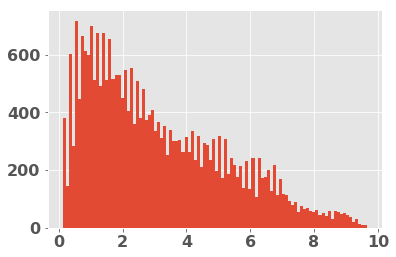

In [45]:
df_dist.distancia.hist(bins=100)

In [46]:
df_num_pozos_cercanos = pd.DataFrame(df_dist.groupby('Pozo').es_cercano.sum()).reset_index()
df_num_pozos_cercanos.columns = ['Pozo','num_pozos_a_menos_de_1km']
df_train = df_train.merge(df_num_pozos_cercanos, how='left',on='Pozo').dropna()

In [47]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud,num_pozos_a_menos_de_1km
0,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,186.59,...,0,1,0,0,0,0,0,17.985929,-94.370707,14
1,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,197.52,...,0,0,1,0,0,0,0,17.985929,-94.370707,14
2,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,215.72,...,0,0,0,1,0,0,0,17.985929,-94.370707,14
3,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,185.47,...,0,0,0,0,1,0,0,17.985929,-94.370707,14
4,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,137.72,...,0,0,0,0,0,1,0,17.985929,-94.370707,14


# Variable de tecnologia
Se le pega el nombre del equipo de perforacion para saber si es mejor o peor para la produccion

In [48]:
# pegar a pozo nombre_equipo_perfo
nombre_equi_perfo = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['NOMBRE_EQUIPO_DE_PERFORACION'].first())
nombre_equi_perfo.reset_index(inplace=True)
nombre_equi_perfo.columns = ['Pozo','equipo_perforacion']
# se encontraron inconsistencias en la info
nombre_equi_perfo["equipo_perforacion"] = nombre_equi_perfo.equipo_perforacion.str.replace(
    "PM5597-","PM-5597").str.replace(
    "PM.-5597","PM-5597").str.replace(
    "PM.5599","PM-5599")
nombre_equi_perfo.head()

,Pozo,equipo_perforacion
0,MOLOACAN-1,SIN INFORMACION
1,MOLOACAN-101,SIN INFORMACION
2,MOLOACAN-102,SIN INFORMACION
3,MOLOACAN-102A,PM-5597
4,MOLOACAN-11,PM-111


In [49]:
df_train = df_train.merge(nombre_equi_perfo, how='left',on='Pozo').dropna()

In [50]:
df_train = pd.get_dummies(df_train, columns=['equipo_perforacion'])

In [51]:
df_train.shape

(20059, 114)

# variable clasificaccion LAHEE
La Clasificación Lahee, los pozos pueden ser identificados como:
+ Pozo Exploratorio
+ Pozos Productores
+ Pozos no Productores (Secos)
+ Pozos de Desarrollo
+ Pozo de Avanzada

Codigos

    07-07-01 - Pozo de desarrollo, productor aceite
    07-07-06 - Pozo de desarrollo, improductivo, invadido de agua salada
    07-07-13 - 07 Pozo de desarrollo
    07-07-04 - Pozo de desarrollo, productor incosteable
    07-07-07 - Pozo de desarrollo, improductivo seco
    04-04-01 - Pozo en busca de nueva acumulacion en campo ya productor, productor de aceite
    07-01-00 - 07 Pozo de desarrollo
    04-04-06 - Pozo en busca de nueva acumulacion en campo ya productor, improductivo, invadido de agua salada
    01-01-06 - Pozo en busca de nueva acumulacion, improductivo, invadido de agua salada
    SIN INFORMACION

Referencia de codigos https://bndh.gob.do/wp-content/uploads/2016/04/4.3-MEM-BNDH-RD-Tercer-Informe-de-Avances_v2-1.pdf


NO VALE LA PENA TODOS LOS POZOS SON DE DESARROLLO O SIN INFORMACION

In [52]:
# clasifi_lahee = pd.DataFrame(datos_generales_pozos.groupby(
#     'NOMBRE_DE_POZO')['CLASIFICACION_LAHEE'].first())
# clasifi_lahee.reset_index(inplace=True)
# clasifi_lahee.columns = ['Pozo','clasificacion_lahee']
# clasifi_lahee.head()

In [53]:
# df_train = df_train.merge(clasifi_lahee, how='left',on='Pozo').dropna()

In [54]:
# df_train = pd.get_dummies(df_train, columns=['clasificacion_lahee'])

In [55]:
# df_train.shape

In [56]:
# df_train.head()

# Saturacion y porosidad 
FALTA BITACORA PARA PEGARLE VARIABLES GEOLOGICAS

In [57]:
datos_generales_pozos.columns

Index(['index', 'NOMBRE_DE_POZO', 'LATITUD', 'LONGITUD', 'ZONA_UTM',
       'COORDENADAS_UTM_X', 'COORDENADAS_UTM_Y', 'SISTEMA_DE_REFERENCIA',
       'NOMBRE_PLATAFORMA_PERA\n(Marino / Terrestre)',
       'NOMBRE_EQUIPO_DE_PERFORACION', 'TIPO_AGUJERO_(AGUJERO/REENTRADA)',
       'CLASIFICACION_POZO_(Exploratorio/Desarrollo)', 'CLASIFICACION_LAHEE',
       'ESTADO_ACTUAL_DE_POZO', 'TIRANTE_DE_AGUA_(m)',
       'PROFUNDIDAD_TOTAL_PERFORADA_(m)', 'PROFUNDIDAD_VERTICALIZADA_(m)',
       'PROFUNDIDAD_DE _REFERENCIA_(KB/MR/nivel_del_mar)',
       'ELEVACION_DE_REFERENCIA_(m)', 'ELEVACION_DE_TERRENO_(mTVD)',
       'TRAYECTORIA_(vertical/desviado/horizontal)',
       'TIPO_DE_HIDROCARBUROS_(aceite/gas/condensado)',
       'FECHA_INICIO_PERFORACION_(dd/mm/aaaa)',
       'FECHA_FIN_DE_PERFORACION_(dd/mm/aaaa)',
       'FECHA_DE_TERMINACION_(dd/mm/aaaa)',
       'FECHA_INICIO_PRODUCCION_(dd/mm/aaaa)',
       'FECHA_DE_TAPONAMIENTO_(dd/mm/aaaa)',
       'FORMACION_O_EDAD_(ULTIMA_PERFORADA)'],
   

In [58]:
datos_generales_pozos.head()

,index,NOMBRE_DE_POZO,LATITUD,LONGITUD,ZONA_UTM,COORDENADAS_UTM_X,COORDENADAS_UTM_Y,SISTEMA_DE_REFERENCIA,NOMBRE_PLATAFORMA_PERA (Marino / Terrestre),NOMBRE_EQUIPO_DE_PERFORACION,...,ELEVACION_DE_REFERENCIA_(m),ELEVACION_DE_TERRENO_(mTVD),TRAYECTORIA_(vertical/desviado/horizontal),TIPO_DE_HIDROCARBUROS_(aceite/gas/condensado),FECHA_INICIO_PERFORACION_(dd/mm/aaaa),FECHA_FIN_DE_PERFORACION_(dd/mm/aaaa),FECHA_DE_TERMINACION_(dd/mm/aaaa),FECHA_INICIO_PRODUCCION_(dd/mm/aaaa),FECHA_DE_TAPONAMIENTO_(dd/mm/aaaa),FORMACION_O_EDAD_(ULTIMA_PERFORADA)
0,0,MOLOACAN-1,17.987072,-94.381714,UTM-15,353703.80,1989180.10,NAD-27,MOLOACAN-1,SIN INFORMACION,...,24.48,22.48,VERTICAL,ACEITE/GAS,31/03/1949,16/04/1949,26/06/1949,12/03/1950,SIN INFORMACION,OLIGOCENO
1,1,MOLOACAN-101,17.982659,-94.369994,UTM-15,354941.32,1988682.58,NAD-27,MOLOACAN-101,SIN INFORMACION,...,27.43,24.93,VERTICAL,ACEITE/GAS,01/03/1949,14/03/1949,23/03/1949,SIN INFORMACION,23/03/1949,ENCANTO
2,2,MOLOACAN-102,17.982043,-94.367304,UTM-15,355225.64,1988612.31,NAD-27,MOLOACAN-102,SIN INFORMACION,...,30.75,28.27,VERTICAL,ACEITE/GAS,23/02/1949,04/03/1949,11/03/1949,SIN INFORMACION,12/03/1949,ENCANTO
3,3,MOLOACAN-102A,17.982088,-94.367397,UTM-15,355215.87,1988617.36,NAD-27,MOLOACAN-102,PM-5597,...,0.00,0.00,VERTICAL,ACEITE/GAS,19/07/1973,20/08/1973,20/08/1973,30/09/1973,SIN INFORMACION,ENCANTO
4,4,MOLOACAN-11,17.986597,-94.373105,UTM-15,354615.05,1989120.81,NAD-27,MOLOACAN-11,PM-111,...,38.36,34.45,VERTICAL,ACEITE/GAS,24/10/1966,07/11/1966,11/01/1967,23/11/1967,10/05/2002,ENCANTO


In [59]:
datos_generales_pozos['FORMACION_O_EDAD_(ULTIMA_PERFORADA)'].value_counts()

ENCANTO            273
ANHIDRITA           57
DEPOSITO            26
OLIGOCENO           22
SIN INFORMACION     11
SAL                  1
Name: FORMACION_O_EDAD_(ULTIMA_PERFORADA), dtype: int64

# HACE FALTA UNA BITACORA DE COMO FUERON SUBIENDO PARA PODER PEGAR TODA ESTA INFORMACION

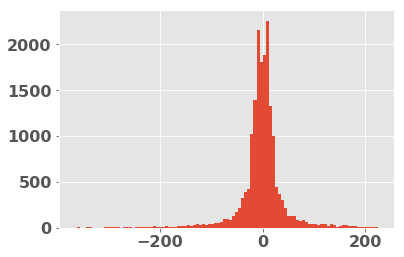

In [121]:
df_train.diff_t_2_t_1.hist(bins=100)

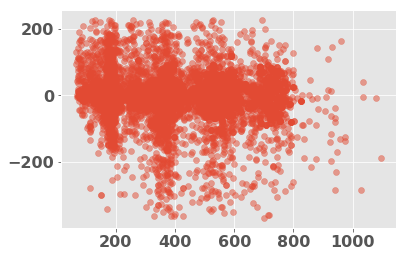

In [122]:
plt.scatter(df_train.Produccion_barriles_t, df_train.diff_t_2_t_1, alpha=0.5)

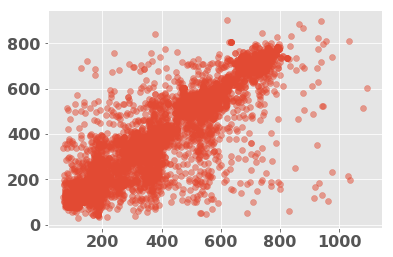

In [123]:
plt.scatter(df_train.Produccion_barriles_t, df_train.media_movil_t_2_t_1, alpha=0.5)

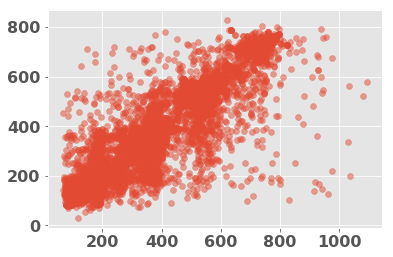

In [125]:
plt.scatter(df_train.Produccion_barriles_t, df_train.media_movil_t_3_t_1, alpha=0.5)

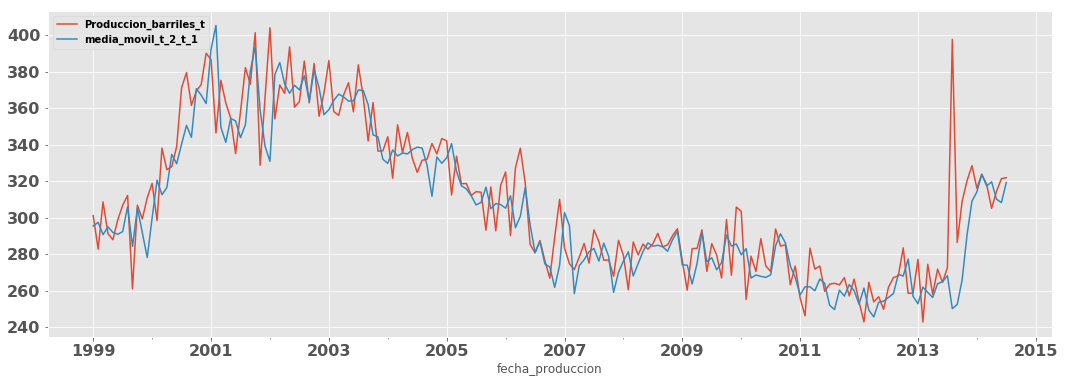

In [128]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','media_movil_t_2_t_1']].mean().plot(figsize=(18,6))

In [133]:
(185.47 + 137.72)/2

161.595

In [131]:
df_train[['media_movil_t_2_t_1','Produccion_barriles_t_2','Produccion_barriles_t_1','Produccion_barriles_t']]

,media_movil_t_2_t_1,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t
0,161.595,185.47,137.72,159.89
1,148.805,137.72,159.89,151.60
2,155.745,159.89,151.60,161.87
3,156.735,151.60,161.87,146.71
4,154.290,161.87,146.71,152.07
5,149.390,146.71,152.07,155.10
6,153.585,152.07,155.10,166.56
7,160.830,155.10,166.56,153.93
8,160.245,166.56,153.93,134.83
9,144.380,153.93,134.83,169.80


# pendiente pico historico

In [62]:
# df_d_prod = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-6).reset_index()
# db_prod_mol['fecha_y'] = df_d_prod.f_prod

In [63]:
# for i in db_prod_mol.groupby('Pozo')[['Qo_mes_b','fecha_produccion','fecha_y']]:
#     print(i[0])
#     print(i[1][i[1].fecha_produccion >= i[1].fecha_y])

In [64]:
# y_temp = []
# for i in sample_prod_data.groupby('API')['Liquid']:
# #     print(i[0])
# #     print(i[1][i[1].index >= idx_prod_max_api[i[0]]].sum())
#     y_temp.append([i[0], i[1][i[1].index >= idx_prod_max_api[i[0]]].sum()])

In [65]:
# idx_prod_max_api = prod_data_train.groupby('API').Liquid.idxmax()

In [66]:
# # AQUI SE CREA LA Y (se puede hacer lista de comprension)
# pico_temp = []
# for i in db_prod_mol.groupby('Pozo')['Qo_mes_b']:
#     pico_temp.append([i[0], i[1][i[1].fecha_produccion >= idx_prod_max_api[i[0]]].sum()])

In [67]:
# db_prod_mol.columns

In [68]:
# db_prod_mol.groupby('Pozo')[['fecha_produccion','f_prod']].last()

In [69]:
# db_prod_mol.groupby(
#     ['Pozo','fecha_produccion'])

In [70]:
df_train.shape

(20059, 114)

## Quitamos Outliers

In [71]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5',
       ...
       'equipo_perforacion_PM-5596', 'equipo_perforacion_PM-5597',
       'equipo_perforacion_PM-5599', 'equipo_perforacion_PM-5620',
       'equipo_perforacion_PM-5626', 'equipo_perforacion_PM-5627',
       'equipo_perforacion_PM-73', 'equipo_perforacion_PM-78',
       'equipo_perforacion_PM-92', 'equipo_perforacion_SIN INFORMACION'],
      dtype='object', length=114)

In [72]:
df_train = df_train[df_train.Produccion_barriles_t > df_train.Produccion_barriles_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_barriles_t_1 > df_train.Produccion_barriles_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_2 > df_train.Produccion_barriles_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_3 > df_train.Produccion_barriles_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_4 > df_train.Produccion_barriles_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_5 > df_train.Produccion_barriles_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_6 > df_train.Produccion_barriles_t_6.quantile(0.001)]

In [73]:
df_train = df_train[df_train.Produccion_barriles_t < df_train.Produccion_barriles_t.quantile(0.99)]

In [74]:
df_train = df_train[df_train.Produccion_barriles_t_1 < df_train.Produccion_barriles_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_2 < df_train.Produccion_barriles_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_3 < df_train.Produccion_barriles_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_4 < df_train.Produccion_barriles_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_5 < df_train.Produccion_barriles_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_6 < df_train.Produccion_barriles_t_6.quantile(0.99)]

In [75]:
df_train = df_train[df_train.diff_t_2_t_1 > df_train.diff_t_2_t_1.quantile(0.005)]
df_train = df_train[df_train.diff_t_2_t_1 < df_train.diff_t_2_t_1.quantile(0.99)]

In [76]:
df_train.reset_index(inplace=True, drop=True)

In [77]:
df_train.shape

(18170, 114)

# Clustering Vemos que hay tipos de pozos con produccion similar

In [ ]:
df_train.head()

In [79]:
np.array(df_train.columns)

array(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'diff_t_12_t_11', 'diff_t_11_t_10', 'diff_t_10_t_9',
       'diff_t_9_t_8', 'diff_t_8_t_7', 'diff_t_7_t_6', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1', 'diff_t_2_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_12_t_11',
       'subio_t_11_t_10', 'subio_t_10_t_9', 'subio_t_9_t_8',
       'subio_t_8_t_7', 'subio_t_7_t_6', 'subio_t_6_t_5', 'subio_t_5_t_4',
       'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t

In [80]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t','dummi_pico_bajo']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t6_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'latitud',
 'longitud',
 'num_pozos_a_menos_de_1km',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5620',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-78',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION']

In [81]:
df_std = (df_train[num_cols] - df_train[num_cols].mean()) / df_train[num_cols].std()

In [82]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=6)
    km = km.fit(df_std)
    Sum_of_squared_distances.append(km.inertia_)

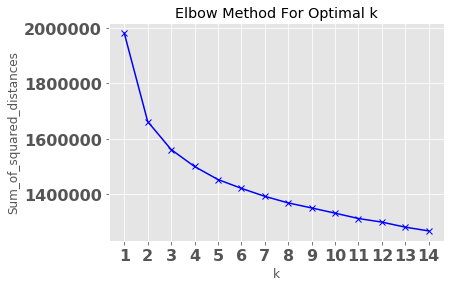

In [83]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(1,15));

In [84]:
kmeans = KMeans(n_clusters=5, n_jobs=6)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=6, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [85]:
df_train = pd.concat([df_train, pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [86]:
df_train["cluster"] = kmeans.predict(df_std)

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [87]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5',
       ...
       'equipo_perforacion_PM-73', 'equipo_perforacion_PM-78',
       'equipo_perforacion_PM-92', 'equipo_perforacion_SIN INFORMACION',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster'],
      dtype='object', length=120)

# AED

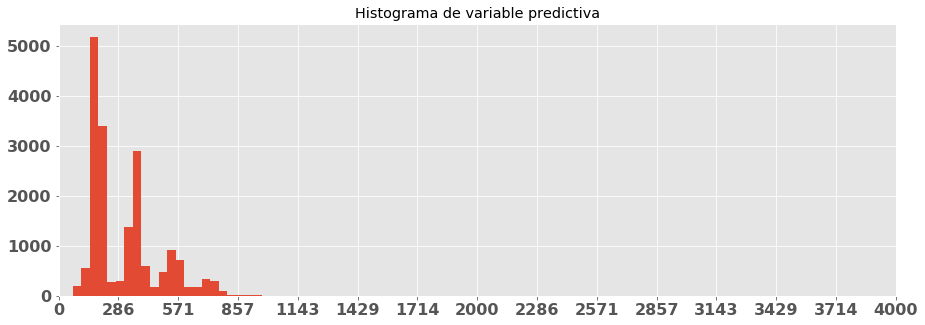

In [88]:
df_train.Produccion_barriles_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
plt.xticks(np.linspace(0,4000,15));

# Dispersiones

In [89]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5',
       ...
       'equipo_perforacion_PM-73', 'equipo_perforacion_PM-78',
       'equipo_perforacion_PM-92', 'equipo_perforacion_SIN INFORMACION',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster'],
      dtype='object', length=120)

En algun momento dibujaras un mapa aqui

In [90]:
# lat = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
# lon = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
# idx = df_train.groupby('Pozo')[['latitud','longitud']].first().index.values

In [91]:
df_prod_heatmap = df_train.set_index('fecha_produccion').groupby([
    'Pozo',pd.Grouper(freq='1Y')]).Produccion_barriles_t.sum()

Text(0.5, 1.0, 'Produccion anual por pozo, historia')

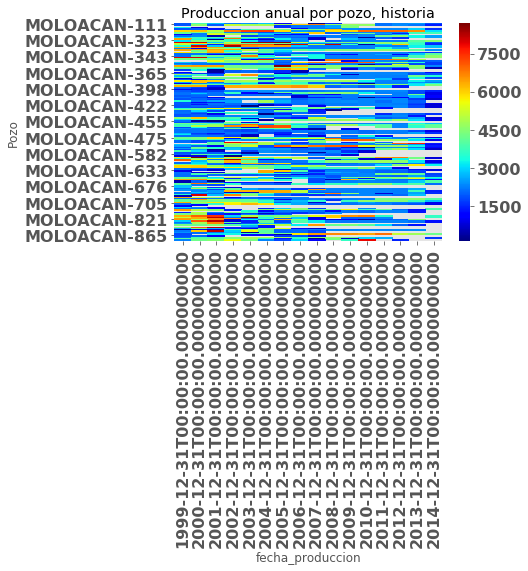

In [92]:
sns.heatmap(df_prod_heatmap.unstack(),cmap='jet')
plt.title('Produccion anual por pozo, historia')

In [93]:
df_prod_heatmap = df_prod_heatmap.reset_index()

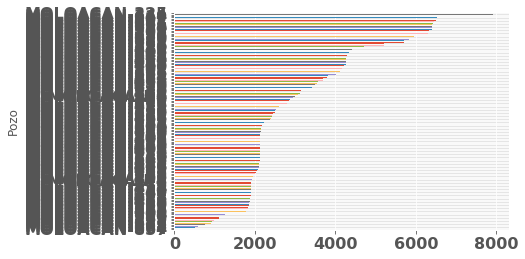

In [94]:
df_prod_heatmap[df_prod_heatmap.fecha_produccion == '1999-12-31'].merge(
    lat_lon_pozo[['Pozo','latitud','longitud']], on='Pozo').set_index('Pozo').Produccion_barriles_t.sort_values().plot.barh()

# heatmap por produccion Pendiente

Text(0.5, 1.0, 'Observamos que hay pozos estables en cantidad de produccion y\n            otros que ascienden o descienden en produccion')

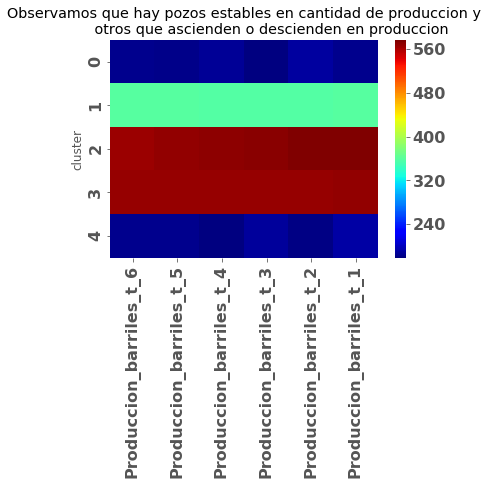

In [95]:
sns.heatmap(df_train.groupby('cluster')[[ 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1']].mean(),cmap='jet')
plt.title('''Observamos que hay pozos estables en cantidad de produccion y
            otros que ascienden o descienden en produccion''')

# Entrenamiento

In [96]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t','dummi_pico_bajo']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t6_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'latitud',
 'longitud',
 'num_pozos_a_menos_de_1km',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5620',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-78',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster']

In [97]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, 
                                                                               num_cols, 'Produccion_barriles_t')

# Conjunto de validacion

In [98]:
y_valid.index.tolist()

[7735,
 10392,
 15318,
 6721,
 6552,
 17853,
 17206,
 17901,
 7175,
 13313,
 6807,
 11445,
 10677,
 14743,
 206,
 13586,
 10951,
 9669,
 6881,
 13925,
 14062,
 983,
 4722,
 14907,
 3186,
 1658,
 4935,
 9695,
 15610,
 4167,
 8088,
 5253,
 7423,
 1157,
 9217,
 11918,
 278,
 9573,
 2306,
 8295,
 11542,
 10994,
 14056,
 1917,
 4371,
 5974,
 6302,
 111,
 11457,
 3836,
 17307,
 7276,
 9519,
 2282,
 7591,
 1635,
 1458,
 16785,
 10484,
 8107,
 8566,
 3290,
 12374,
 1292,
 3310,
 13883,
 9184,
 799,
 6165,
 10787,
 4762,
 3368,
 15927,
 13556,
 12777,
 223,
 8850,
 14314,
 13441,
 10334,
 2901,
 10921,
 4207,
 13424,
 890,
 6583,
 6998,
 3839,
 18122,
 56,
 7664,
 5941,
 15854,
 10462,
 12457,
 14178,
 7018,
 13372,
 2132,
 17352,
 12881,
 1226,
 6804,
 273,
 15370,
 14018,
 15792,
 15160,
 11550,
 169,
 7897,
 14362,
 3190,
 7449,
 3122,
 16556,
 9894,
 11057,
 15957,
 7069,
 6661,
 156,
 8458,
 5176,
 5960,
 10277,
 15902,
 7861,
 10713,
 1927,
 11786,
 11034,
 1410,
 14769,
 12606,
 5632,
 14486,
 1123,
 6112,
 13897,
 10631,
 11994,
 15224,
 4413,
 12597,
 13136,
 15015,
 14880,
 16558,
 1299,
 8494,
 15533,
 13501,
 9070,
 2296,
 14950,
 13281,
 12657,
 14377,
 13704,
 4884,
 331,
 1495,
 16845,
 376,
 15804,
 18149,
 15922,
 3696,
 4968,
 12114,
 6295,
 15166,
 5012,
 8678,
 15229,
 12689,
 7830,
 11023,
 14697,
 16922,
 18100,
 11056,
 12942,
 2990,
 2551,
 14607,
 12023,
 12545,
 16137,
 4225,
 16521,
 11985,
 12708,
 7095,
 10464,
 8611,
 17196,
 16159,
 8975,
 16707,
 4116,
 2046,
 10669,
 11876,
 17246,
 11049,
 365,
 7299,
 16198,
 3861,
 159,
 4585,
 7533,
 7311,
 12298,
 1774,
 11923,
 14735,
 1319,
 17768,
 10226,
 6006,
 15343,
 13654,
 574,
 3216,
 1565,
 9490,
 10588,
 9079,
 252,
 1716,
 14943,
 17024,
 17413,
 942,
 7515,
 7927,
 2157,
 14173,
 10371,
 7516,
 5327,
 4415,
 3890,
 6447,
 6816,
 16040,
 18139,
 5971,
 17053,
 11406,
 1261,
 9541,
 13368,
 1100,
 10477,
 3452,
 3383,
 12240,
 3173,
 5493,
 9664,
 16819,
 16199,
 17572,
 1440,
 8507,
 2548,
 2295,
 14277,
 11564,
 16672,
 11920,
 13822,
 4653,
 5824,
 1331,
 6063,
 288,
 7047,
 16489,
 16536,
 3742,
 4434,
 12753,
 10081,
 4874,
 8439,
 6044,
 3485,
 8756,
 13041,
 3215,
 8796,
 3728,
 2427,
 5917,
 7658,
 8912,
 11634,
 3587,
 3208,
 1325,
 11476,
 11828,
 4558,
 9364,
 10985,
 15289,
 11613,
 16751,
 16042,
 4741,
 11429,
 15386,
 7609,
 15585,
 17454,
 15013,
 10970,
 2318,
 6891,
 9941,
 4195,
 1940,
 10997,
 1958,
 16645,
 6615,
 1908,
 15248,
 3431,
 15463,
 14530,
 4255,
 5585,
 15958,
 3597,
 9951,
 5003,
 12456,
 243,
 5089,
 10249,
 10026,
 9950,
 17501,
 16449,
 10965,
 1939,
 7898,
 112,
 17073,
 16996,
 17304,
 13757,
 1354,
 2862,
 7233,
 11206,
 11084,
 11766,
 5148,
 9284,
 13496,
 17552,
 16368,
 1588,
 12336,
 14834,
 654,
 16519,
 676,
 13574,
 15721,
 1013,
 13479,
 2694,
 17679,
 4055,
 14244,
 644,
 1955,
 490,
 9622,
 11687,
 17442,
 5634,
 11142,
 256,
 5415,
 17897,
 14376,
 12824,
 3386,
 15818,
 10667,
 7937,
 10235,
 10634,
 3987,
 1531,
 10846,
 16068,
 16765,
 6996,
 13791,
 3720,
 2155,
 3033,
 11017,
 10274,
 17735,
 8960,
 5858,
 15565,
 6493,
 1852,
 14158,
 10215,
 17719,
 1996,
 3759,
 9244,
 8236,
 9278,
 4132,
 14857,
 8066,
 8671,
 9121,
 13229,
 12579,
 9970,
 8174,
 14441,
 9081,
 12925,
 3363,
 16254,
 10271,
 5545,
 1294,
 1433,
 5450,
 16108,
 10454,
 11354,
 2327,
 3300,
 18157,
 268,
 15241,
 8691,
 13658,
 2332,
 12826,
 8073,
 3638,
 8095,
 6329,
 928,
 8286,
 16144,
 5680,
 2590,
 15028,
 2639,
 8972,
 17701,
 5825,
 13235,
 11976,
 16058,
 14613,
 8958,
 6723,
 2557,
 1436,
 10936,
 5642,
 6872,
 5758,
 5552,
 782,
 1318,
 1453,
 13986,
 2664,
 13467,
 15167,
 5523,
 9210,
 11461,
 6942,
 11480,
 10597,
 9104,
 5356,
 9538,
 4713,
 7193,
 16892,
 8844,
 10883,
 16854,
 1550,
 4440,
 5458,
 16986,
 6535,
 15841,
 15626,
 8342,
 17448,
 1428,
 3677,
 7336,
 2215,
 1957,
 6265,
 18016,
 6734,
 9755,
 10193,
 526,
 16999,
 1711,
 15549,
 1633,
 6970,
 2100,
 1114,
 15708,
 13008,
 12995,
 13484,
 14004,
 987

# seguimos entrenando

In [99]:
x_train.shape

(13082, 115)

In [100]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1815]	valid_0's l1: 21.0233


In [101]:
clf.num_trees()

1815

# Evaluacion

In [102]:
y_pred = clf.predict(x_valid)

In [103]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))
    

In [104]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

R^2: 0.9150
R^2 ajustada$: 0.9093
MEA: 20.0575
MSE 2213.7696
RMSE 47.0507


In [105]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

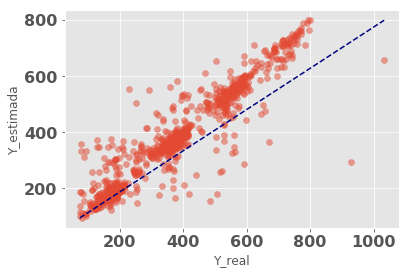

In [106]:
yy_plot(y_valid, y_pred)

## Residuos

In [107]:
res = (y_valid - y_pred) / y_valid

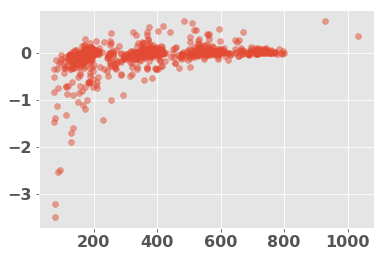

In [108]:
plt.scatter(y_valid, res, alpha=0.5)

In [109]:
res.median() * 100

0.08051675727355899

In [110]:
res.mean() * 100

-2.862175137501673

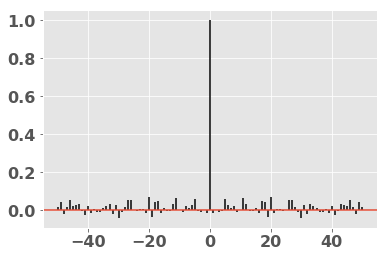

In [111]:
plt.xcorr(res, res,maxlags=50, usevlines=1)
plt.show()

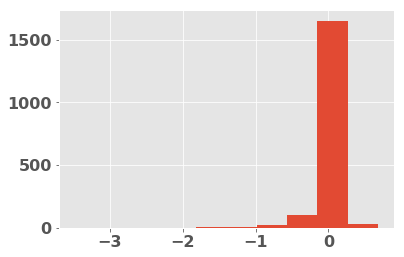

In [112]:
res.hist()

## Autocorrelacion

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

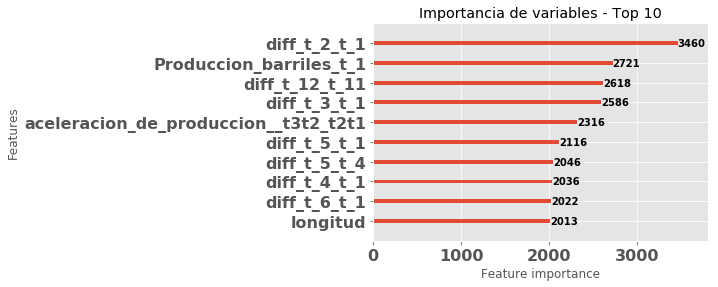

In [113]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [114]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [115]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [116]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [117]:
a.tail(8).index

Index(['diff_t_4_t_1', 'diff_t_5_t_4', 'diff_t_5_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'diff_t_3_t_1',
       'diff_t_12_t_11', 'Produccion_barriles_t_1', 'diff_t_2_t_1'],
      dtype='object')

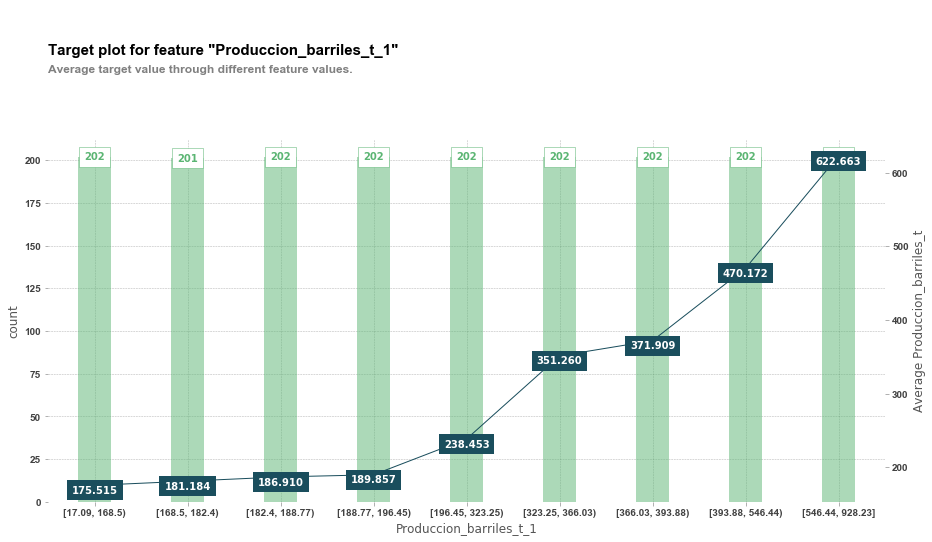

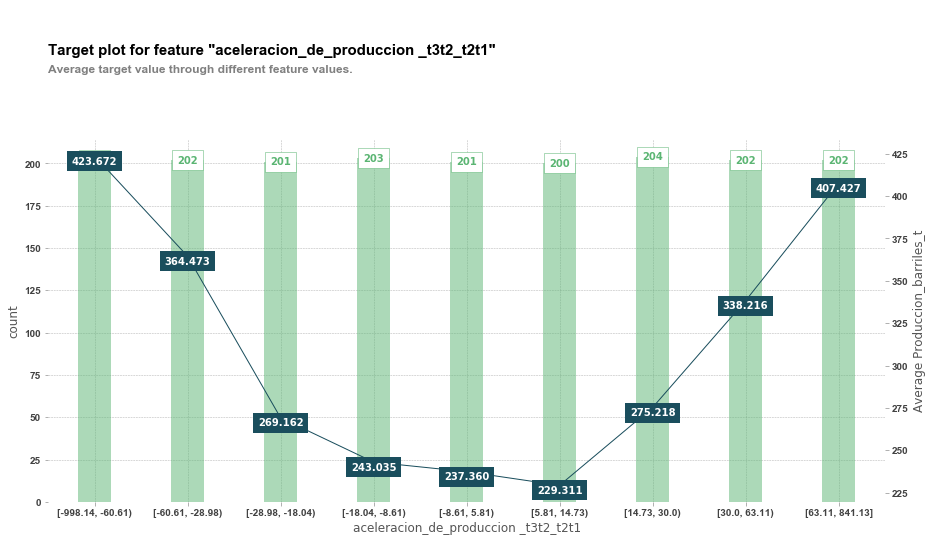

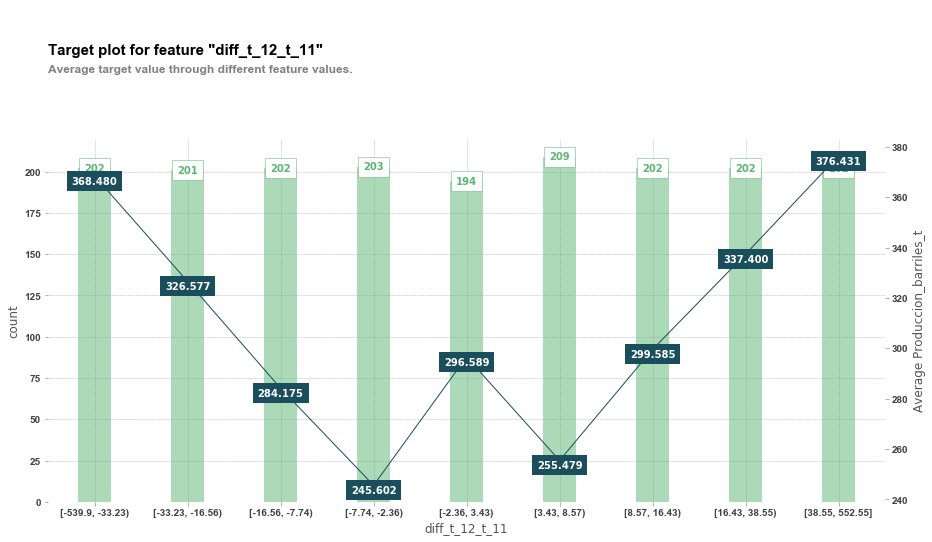

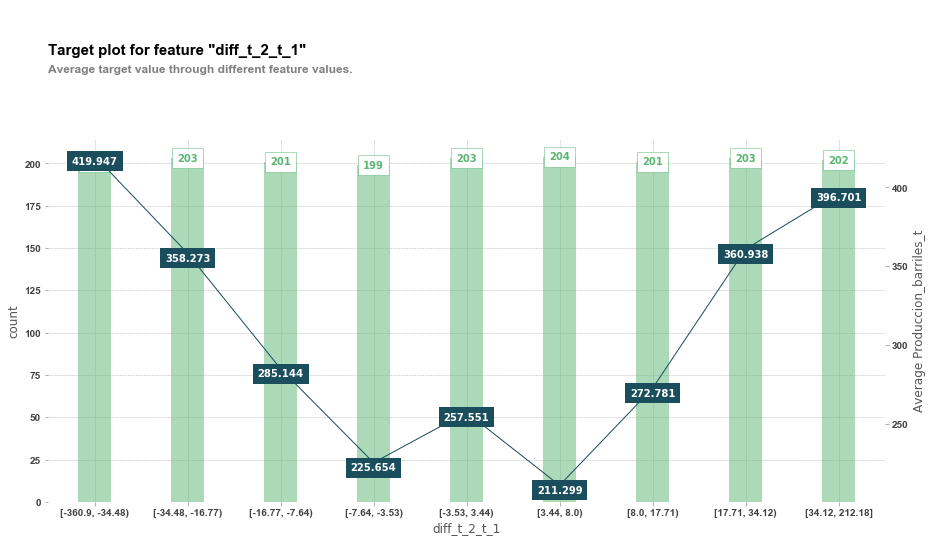

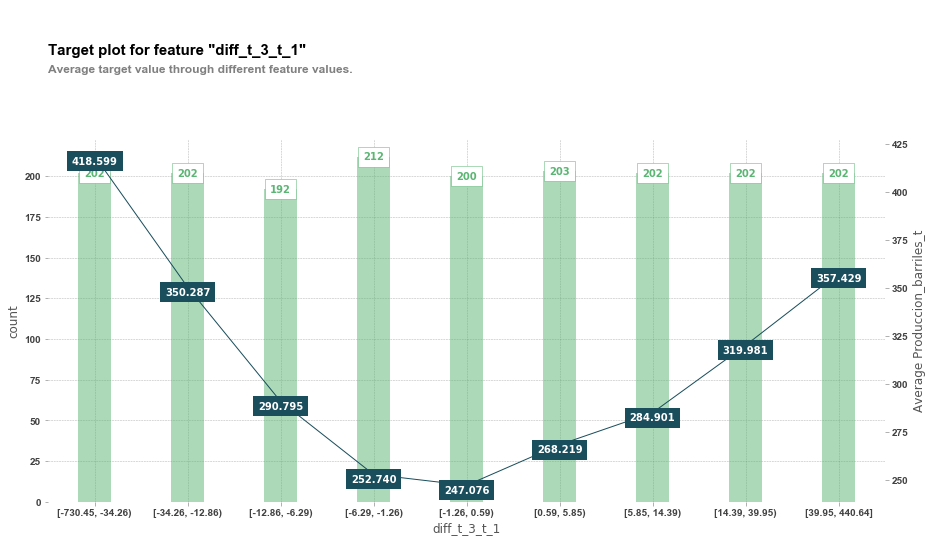

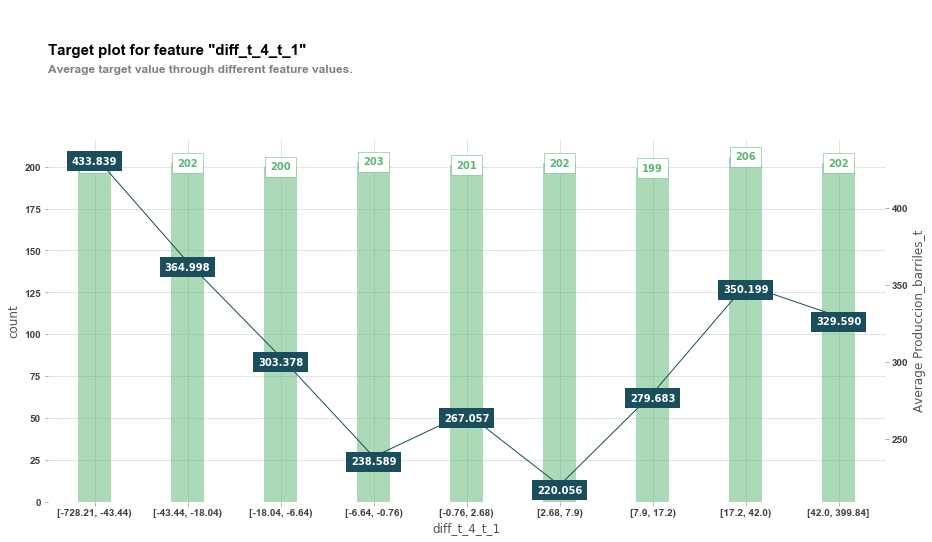

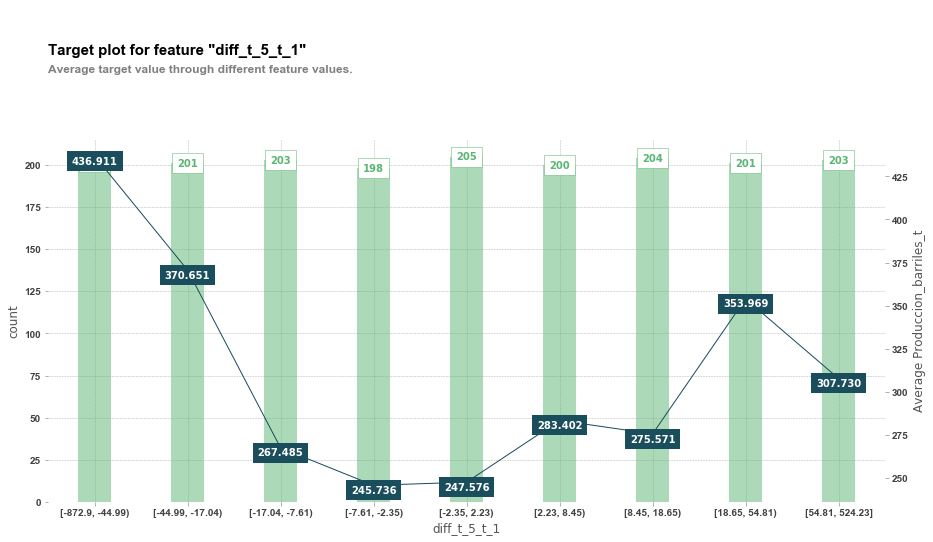

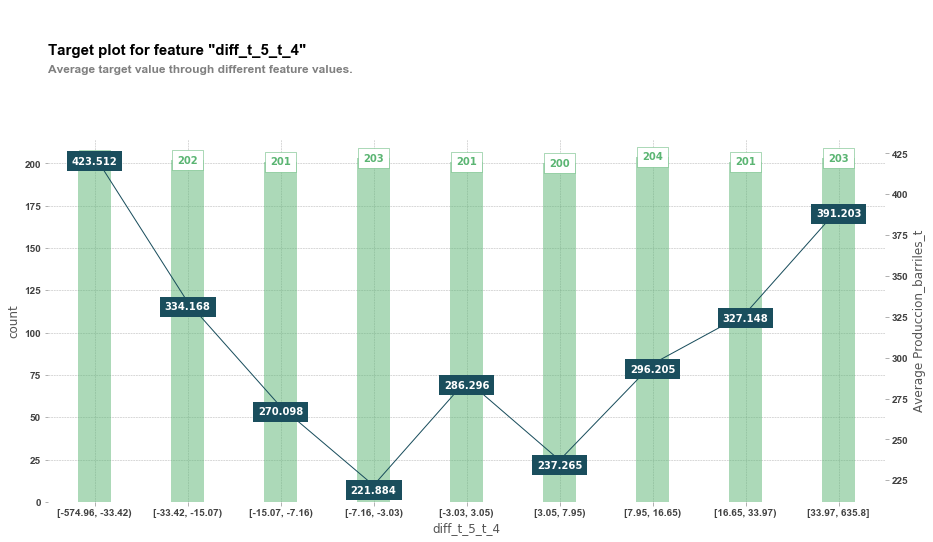

In [118]:
for col in sorted(a.tail(8).index):
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        , feature=col, 
        feature_name=col, 
        target='Produccion_barriles_t'
    )

In [119]:
inter_rf = pdp.pdp_interact(
    model=clf, dataset=pd.concat([x_valid,y_valid],1), model_features=['latitud', 'longitud'], 
    features=['latitud', 'longitud']
)

In [129]:
# fig, axes = pdp.pdp_interact_plot(
#     x_valid, ['latitud', 'longitud'], x_quantile=True, plot_type='contour', plot_pdp=True
# )

## Pendiente interpretar los de shap

In [ ]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Guardado de mejor modelo

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'light_gbm_oil_01-08-2019.pkl')
# load model
# gbm_pickle = joblib.load('light_gbm_31-07-2019.pkl')

In [ ]:
# carga de modelo
# gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Check de pozos aleatorios

In [ ]:
idx = df_train.Pozo.sample(10)

In [ ]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().index

In [ ]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().unstack(0)

In [ ]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [ ]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

In [ ]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [ ]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [ ]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_barriles_t

In [ ]:
df_train['prediction'] = preds

In [ ]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [ ]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

In [ ]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [ ]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [ ]:
df_vivos = df_vivos[df_vivos.fecha_produccion > '2003-12-01']

In [ ]:
a = df_vivos.groupby('Pozo').fecha_produccion.min()
idx_a = a[a=='2004-01-01'].index

In [ ]:
df_vivos = df_vivos[df_vivos.Pozo.isin(idx_a)]

In [ ]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [ ]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.Produccion_barriles_t - df_vivos2.prediction

In [ ]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

In [672]:
# df_vivos2.to_csv("perfiles_pozo.csv")

# Modelo de Gas

# Entrenamiento

In [303]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','prediction','prediction_oil','prediction_gas']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_6_t_1',
 'median_t_6_t_1',
 'min_t_6_t_1',
 'q75_t_6_t_1',
 'q25_t_6_t_1',
 'q90_t_6_t_1',
 'q10_t_6_t_1',
 'max_t_6_t_1',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t6_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'latitud',
 'longitud',
 'num_pozos_a_menos_de_1km',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5620',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-78',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster']

In [304]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, 
                                                                               num_cols, 'Produccion_gasMMpc_t')

# Conjunto de validacion

In [305]:
y_valid.index.tolist()

[1007,
 8059,
 10851,
 11823,
 17432,
 11907,
 3327,
 3017,
 8196,
 6538,
 6389,
 4850,
 10905,
 112,
 9652,
 8498,
 12641,
 2751,
 17862,
 12626,
 2803,
 17819,
 10902,
 8095,
 4702,
 9543,
 5174,
 1600,
 7339,
 11004,
 15929,
 4926,
 18132,
 11052,
 14029,
 2811,
 5954,
 14667,
 1989,
 14290,
 13095,
 18033,
 16411,
 5743,
 3523,
 4960,
 834,
 2836,
 7327,
 9711,
 16175,
 15482,
 1231,
 12349,
 3243,
 13559,
 8073,
 6200,
 3696,
 9120,
 18191,
 10837,
 16697,
 13867,
 12330,
 18247,
 2306,
 10187,
 9295,
 9270,
 15212,
 17923,
 10601,
 196,
 6002,
 10115,
 16097,
 223,
 18010,
 12598,
 8495,
 15105,
 6721,
 10420,
 11977,
 3730,
 7764,
 2288,
 17307,
 3033,
 4385,
 14058,
 14218,
 15545,
 2314,
 12084,
 3208,
 7093,
 9409,
 1916,
 16051,
 17722,
 17687,
 13424,
 9384,
 12399,
 2858,
 490,
 9670,
 6236,
 169,
 10452,
 3143,
 942,
 1547,
 8877,
 4573,
 11310,
 8975,
 3585,
 732,
 13050,
 18320,
 7894,
 520,
 2416,
 2557,
 945,
 1588,
 9078,
 13196,
 8963,
 5335,
 3799,
 17990,
 9100,
 1093,
 4010,
 17011,
 16373,
 9895,
 4754,
 2058,
 4966,
 17761,
 5728,
 10355,
 13601,
 4443,
 7550,
 18321,
 8926,
 3004,
 9849,
 13987,
 12181,
 3774,
 9661,
 16866,
 16977,
 5136,
 6747,
 4016,
 13297,
 11219,
 11782,
 5232,
 10921,
 14327,
 8590,
 9653,
 887,
 6190,
 18041,
 5933,
 7023,
 2249,
 13292,
 8160,
 3052,
 17460,
 17864,
 18422,
 5411,
 17642,
 11413,
 3521,
 17350,
 11249,
 6653,
 2981,
 252,
 7916,
 13949,
 206,
 15573,
 2072,
 15401,
 5356,
 8006,
 3983,
 18015,
 4851,
 7960,
 18382,
 5651,
 1458,
 3772,
 9284,
 9709,
 9164,
 18318,
 12115,
 14518,
 13120,
 16735,
 7069,
 8925,
 4823,
 7667,
 17675,
 4338,
 4058,
 1226,
 18093,
 4538,
 8321,
 16125,
 11978,
 5721,
 17036,
 10638,
 7927,
 11335,
 5963,
 18384,
 3919,
 9806,
 12863,
 10008,
 977,
 3362,
 2639,
 7195,
 3836,
 9019,
 17775,
 17415,
 14566,
 15494,
 6245,
 13883,
 13744,
 5724,
 10691,
 4434,
 16434,
 11026,
 7786,
 6076,
 1188,
 15075,
 1917,
 17737,
 5828,
 14860,
 6258,
 5159,
 9723,
 8932,
 4409,
 14942,
 2335,
 6977,
 17144,
 4901,
 15410,
 14465,
 288,
 7496,
 1374,
 10567,
 10444,
 16092,
 17702,
 16331,
 5680,
 1701,
 16326,
 2081,
 5977,
 6897,
 13318,
 11123,
 13794,
 2135,
 14812,
 16840,
 11420,
 1939,
 8015,
 6415,
 1114,
 17927,
 6115,
 15374,
 2327,
 16979,
 7232,
 17333,
 5889,
 376,
 14608,
 12649,
 8365,
 11806,
 1868,
 7321,
 9583,
 11825,
 17799,
 14934,
 7744,
 1820,
 7258,
 13563,
 15626,
 8940,
 5490,
 5545,
 1302,
 16855,
 16104,
 355,
 6072,
 16848,
 4196,
 8379,
 6840,
 2361,
 10068,
 10499,
 15037,
 15918,
 782,
 16421,
 10872,
 10827,
 3599,
 1436,
 14695,
 4210,
 9526,
 15541,
 15294,
 10883,
 701,
 1223,
 15477,
 5477,
 16521,
 473,
 5153,
 10762,
 10264,
 17014,
 3396,
 11222,
 14079,
 8660,
 858,
 11849,
 13584,
 2153,
 12520,
 14097,
 1122,
 5519,
 10303,
 3681,
 7422,
 3759,
 4306,
 17462,
 7656,
 10708,
 1967,
 17468,
 12095,
 14765,
 9369,
 10737,
 11632,
 943,
 16542,
 12930,
 5795,
 1882,
 4225,
 10530,
 111,
 9116,
 16607,
 14372,
 9475,
 3862,
 662,
 14728,
 17226,
 1780,
 16482,
 9904,
 56,
 8974,
 12328,
 13128,
 10381,
 5824,
 10141,
 1009,
 17974,
 11235,
 10793,
 11914,
 14531,
 1331,
 13898,
 17070,
 7112,
 15253,
 16238,
 1550,
 14616,
 18168,
 13392,
 5806,
 15042,
 2755,
 18364,
 7223,
 1175,
 5529,
 12259,
 12223,
 3610,
 2102,
 4909,
 8652,
 16347,
 117,
 16907,
 8393,
 3528,
 5238,
 2427,
 15687,
 273,
 2542,
 6602,
 3488,
 5193,
 11717,
 7731,
 15751,
 1633,
 6681,
 2484,
 8687,
 6485,
 3465,
 15539,
 14748,
 17730,
 1180,
 11664,
 1294,
 4015,
 5627,
 4843,
 17816,
 2242,
 13001,
 15728,
 9045,
 10546,
 7217,
 1773,
 11448,
 7012,
 6447,
 15680,
 4342,
 7277,
 17475,
 17424,
 6902,
 11990,
 11112,
 11233,
 5565,
 15135,
 8153,
 5421,
 13702,
 1299,
 5200,
 10346,
 3658,
 13796,
 7451,
 306,
 6031,
 14510,
 11499,
 16926,
 156,
 8351,
 11996,
 17717,
 14654,
 12825,
 2215,
 4917,
 2762,
 4837,
 1970,
 2917,
 3768,
 7449,
 12990,
 4123,
 14585,
 1326,
 15791,
 12113,
 15170,
 10043,
 4032,
 1390,
 4913,
 1026,
 386

# seguimos entrenando

In [306]:
x_train.shape

(13281, 123)

In [307]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
[10000]	valid_0's l1: 0.0175345
Early stopping, best iteration is:
[14247]	valid_0's l1: 0.0174489


In [308]:
clf.num_trees()

14247

# Evaluacion

In [309]:
y_pred = clf.predict(x_valid)

In [310]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))
    

In [311]:
y_valid.mean()

0.18416802168021806

In [312]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

R^2: 0.8735
R^2 ajustada$: 0.8645
MEA: 0.0174
MSE 0.0026
RMSE 0.0505


In [313]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

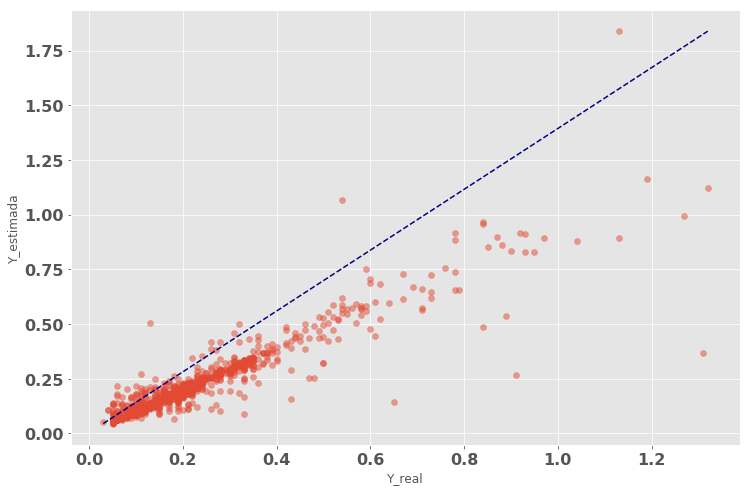

In [314]:
yy_plot(y_valid, y_pred)

## Residuos

In [315]:
res = (y_valid - y_pred) / y_valid

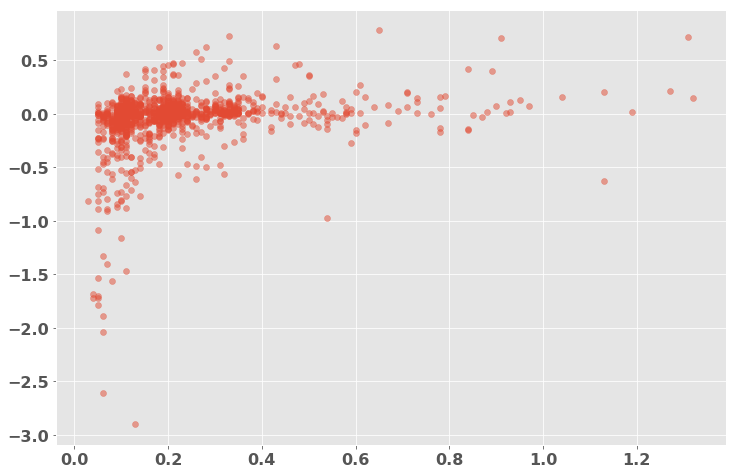

In [316]:
plt.scatter(y_valid, res, alpha=0.5)

In [317]:
res.median() * 100

0.20670568696366923

In [318]:
res.mean() * 100

-2.6107519718219905

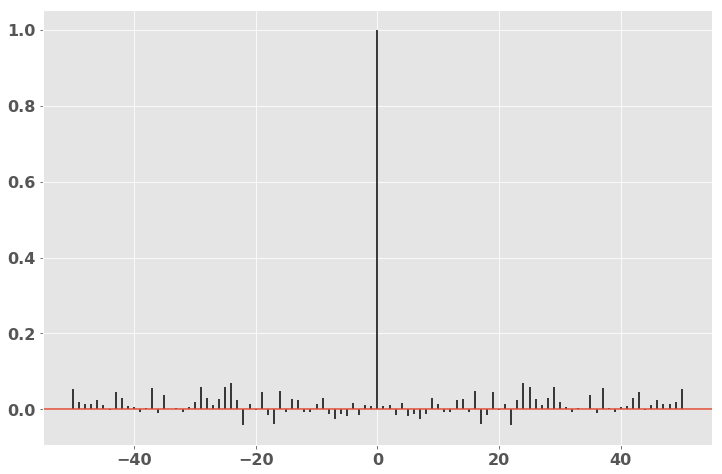

In [319]:
plt.xcorr(res, res,maxlags=50, usevlines=1)
plt.show()

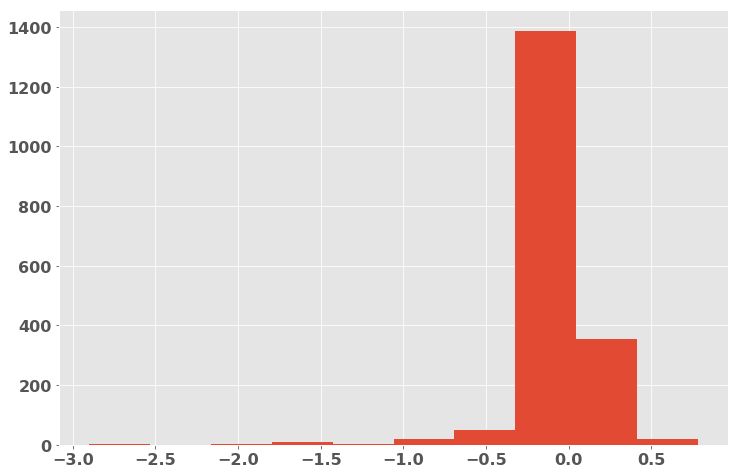

In [320]:
res.hist()

## Autocorrelacion

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

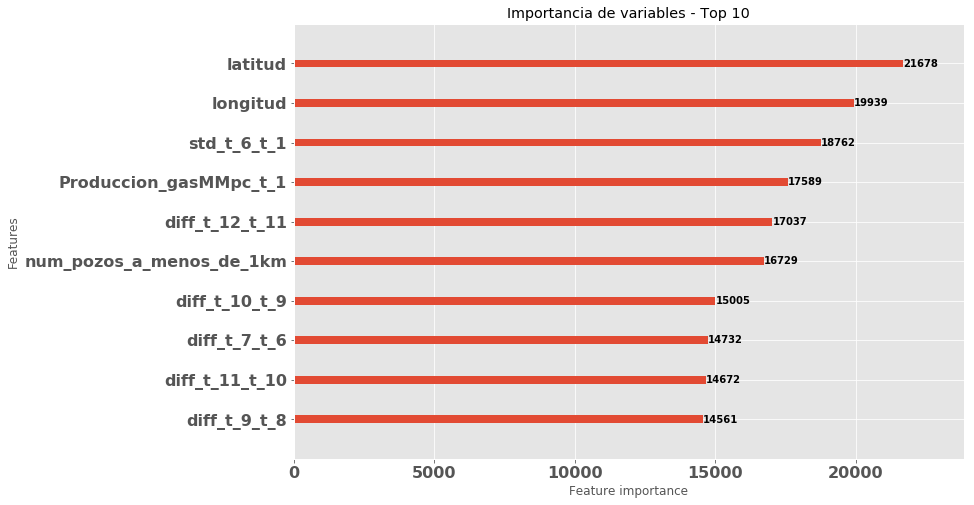

In [321]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [322]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [323]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [324]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [325]:
a.tail(8).index

Index(['diff_t_7_t_6', 'diff_t_10_t_9', 'num_pozos_a_menos_de_1km',
       'diff_t_12_t_11', 'Produccion_gasMMpc_t_1', 'std_t_6_t_1', 'longitud',
       'latitud'],
      dtype='object')

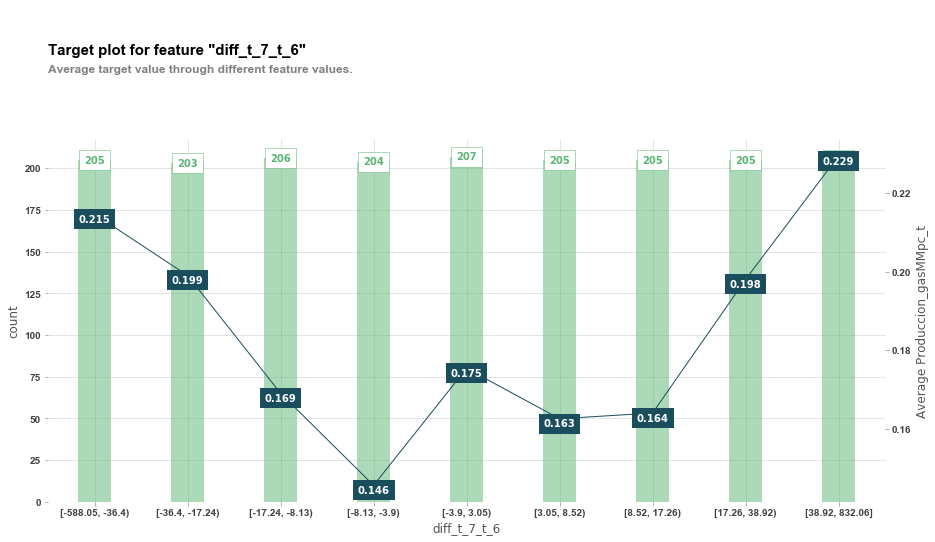

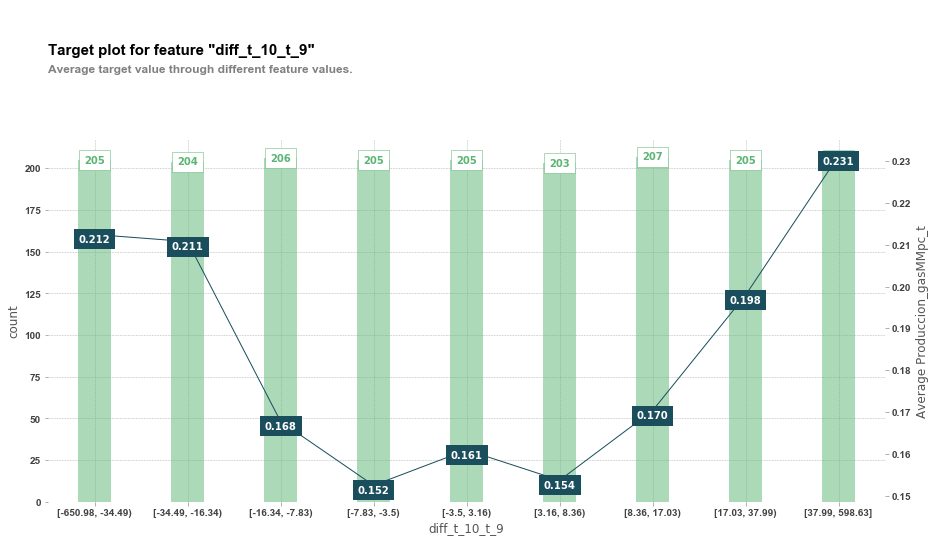

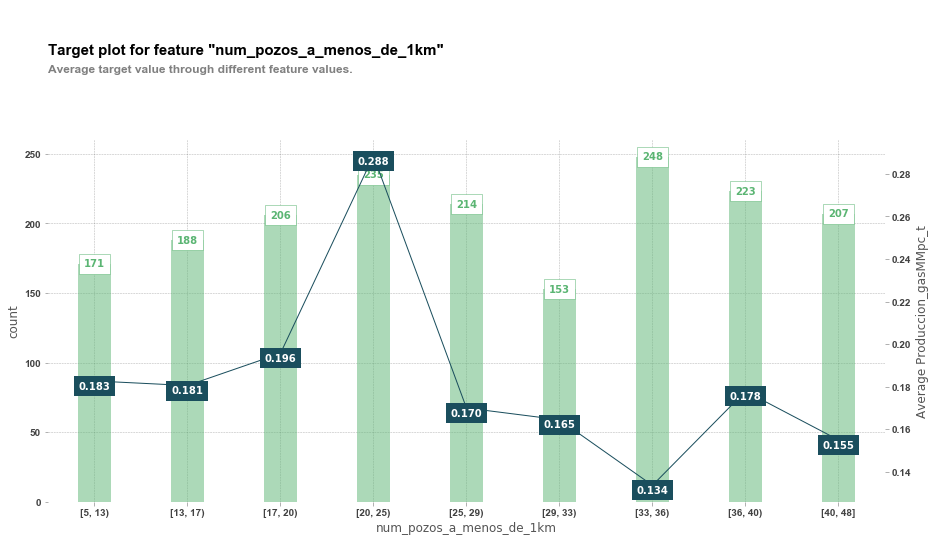

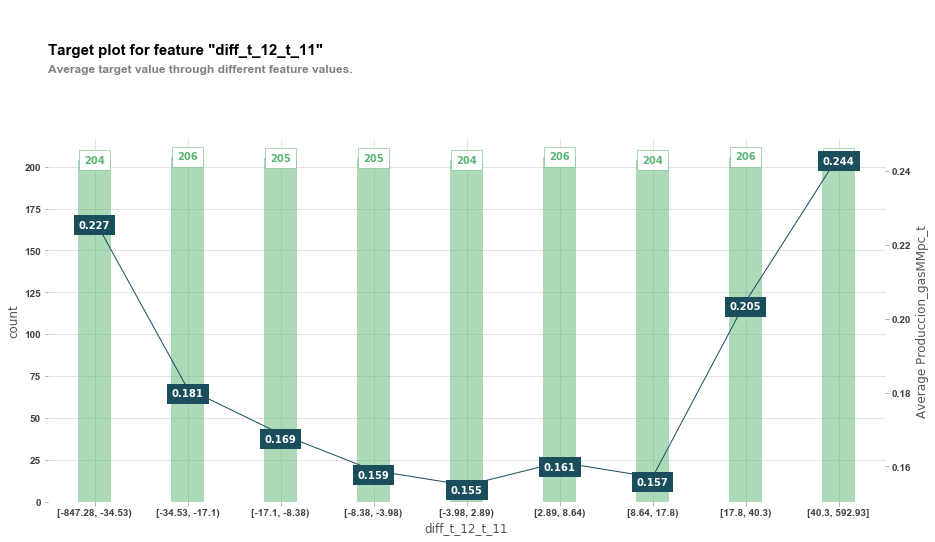

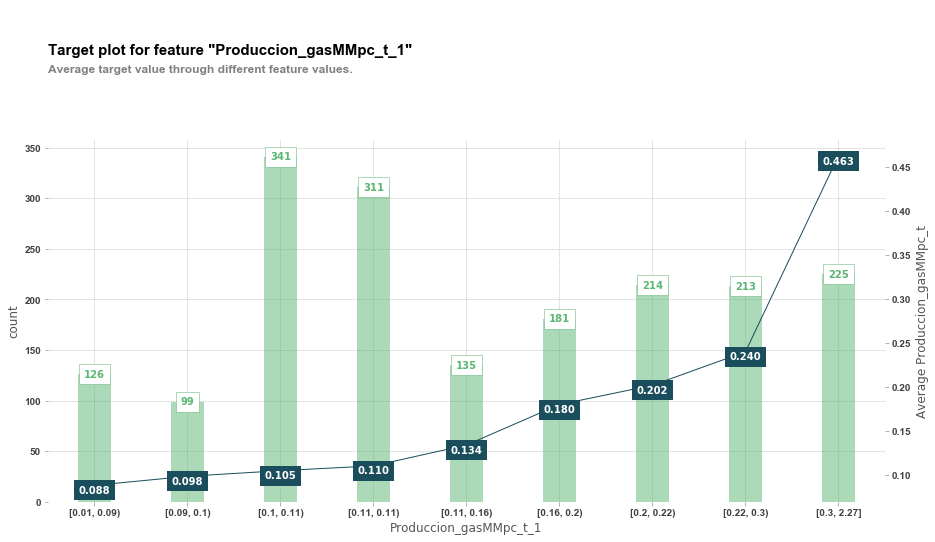

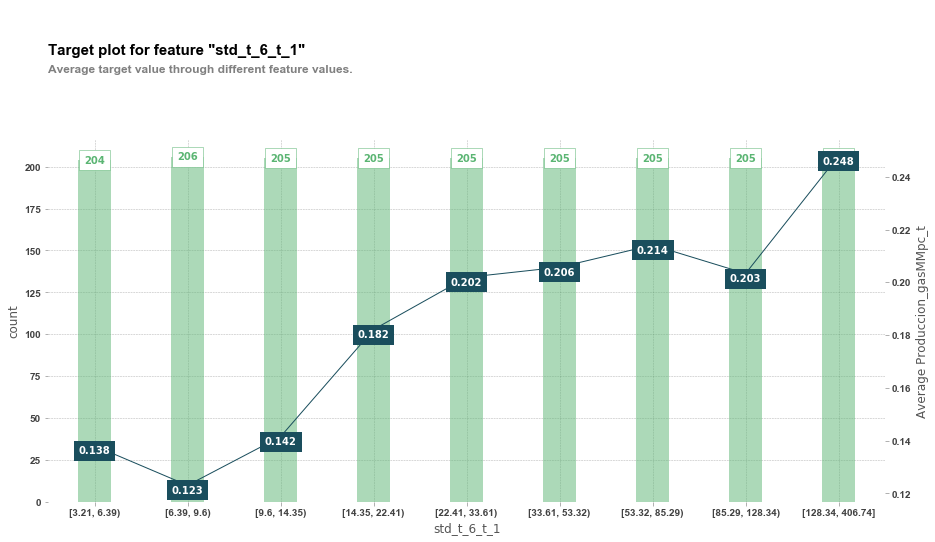

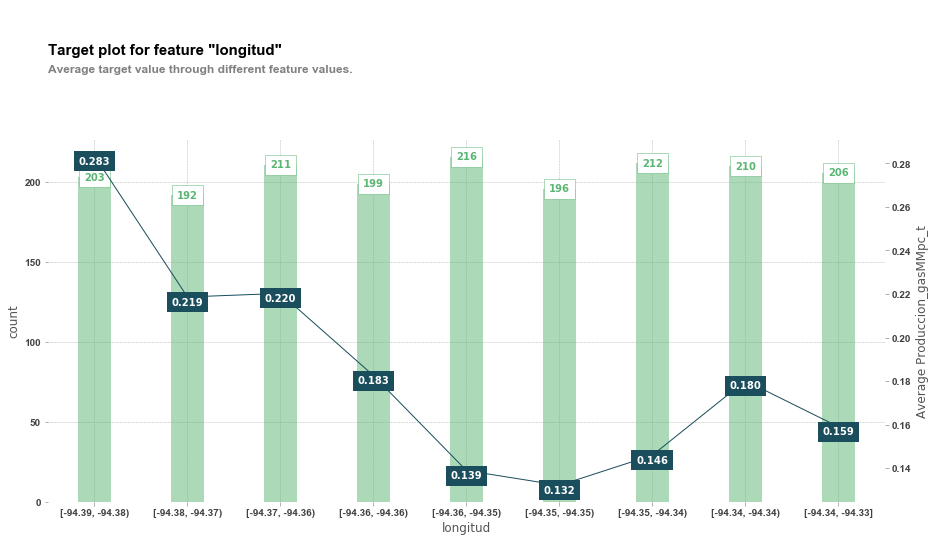

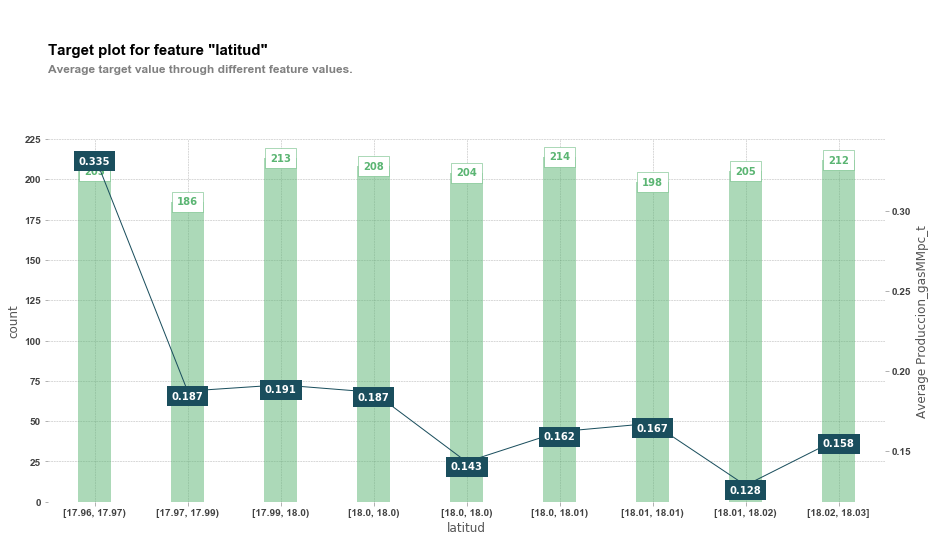

In [326]:
for col in a.tail(8).index:
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        , feature=col, 
        feature_name=col, 
        target='Produccion_gasMMpc_t'
    )

## Pendiente interpretar los de shap

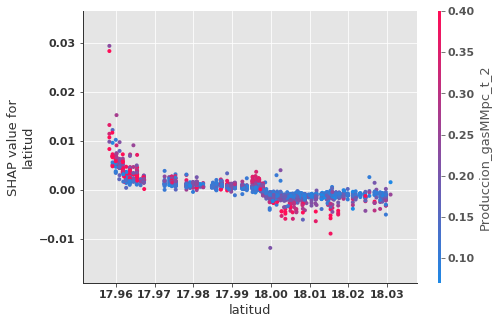

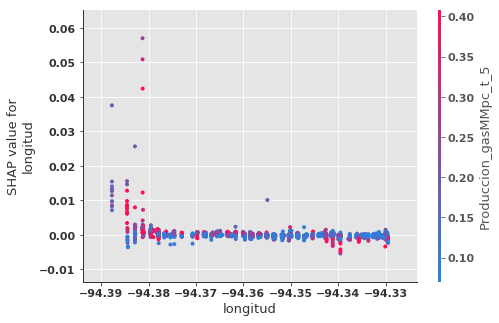

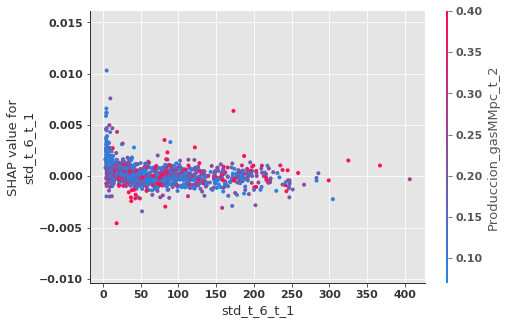

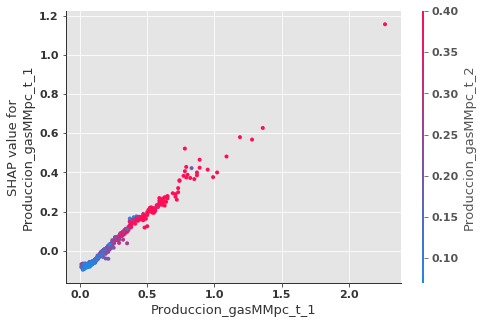

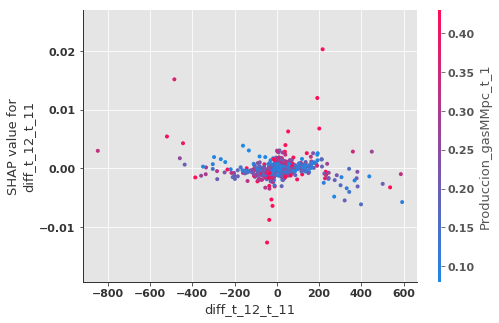

In [327]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Guardado de mejor modelo

In [328]:
joblib.dump(clf, 'light_gbm_gas_01-08-2019.pkl')
# load model
# gbm_pickle = joblib.load('light_gbm_31-07-2019.pkl')

['light_gbm_gas_01-08-2019.pkl']

In [329]:
# carga de modelo
# gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Check de pozos aleatorios

In [330]:
idx = df_train.Pozo.sample(10)

In [331]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_gasMMpc_t.first().index

In [332]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_gasMMpc_t.first().unstack(0)

In [333]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [334]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

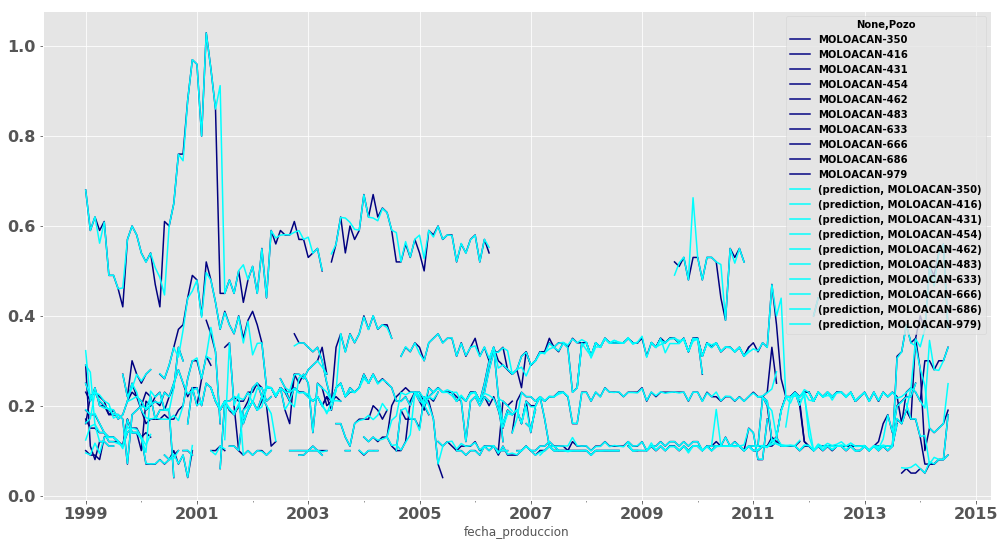

In [335]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [336]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [337]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_gasMMpc_t

In [338]:
df_train['prediction_gas'] = preds

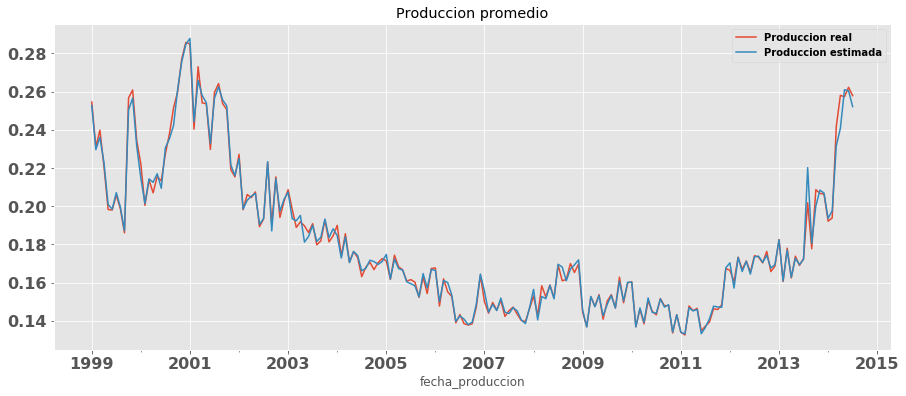

In [339]:
df_train.groupby('fecha_produccion')[['Produccion_gasMMpc_t','prediction_gas']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [340]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

108.0

In [341]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [342]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [343]:
df_vivos = df_vivos[df_vivos.fecha_produccion > '2003-12-01']

In [344]:
a = df_vivos.groupby('Pozo').fecha_produccion.min()
idx_a = a[a=='2004-01-01'].index

In [345]:
df_vivos = df_vivos[df_vivos.Pozo.isin(idx_a)]

In [346]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [347]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_gasMMpc_t','prediction_gas']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_gasMMpc_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_gasMMpc_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction_gas'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction_gas'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.Produccion_gasMMpc_t - df_vivos2.prediction_gas

In [348]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

In [349]:
df_vivos2.to_csv("perfiles_pozo_gas.csv")